# Retrieval Augmented Generation

Student: Joan Verguizas I Moliner

Course: Natural Language Processing

Programme: Physics of Data

A.Y: 2023-2024

The project consist in developing a Retreival Augmented Generation programe for the domain of our choice. In this case, we are going to build a RAG application for retrieving questions about Sherlock Holmes books.

In [1]:
# install the required packages

!pip install -U -q "kaggle" "langchain" "transformers==4.31.0" "datasets==2.13.0" "peft==0.4.0" "accelerate" "bitsandbytes==0.40.2" "trl==0.4.7" "safetensors>=0.3.1" "langchain_community" "faiss-cpu" "tiktoken" "sentence-transformers" "huggingface-hub" "xformers" "langchain-chroma"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 102.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.8 MB/s et

In [2]:
# import libraries

import os
import torch
import transformers
import accelerate
import re
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain.embeddings import CacheBackedEmbeddings, HuggingFaceEmbeddings
from langchain.vectorstores import FAISS, Chroma
from langchain.storage import LocalFileStore
from langchain.llms import HuggingFacePipeline
from langchain.chains import RetrievalQA
from langchain.callbacks import StdOutCallbackHandler
from langchain.schema import Document
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain_chroma import Chroma


/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in HuggingFaceInferenceAPIEmbeddings has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [3]:
# login credentials to access huggingface models

# need the huggingface token

from huggingface_hub import notebook_login
notebook_login()


## Domain & Dataset

Sherlock Holmes is an universaly known series of books written by Sir Arthur Conan Doyle. In this project, the dataset we are going to use can be downloaded from this [Kaggle repository](https://www.kaggle.com/datasets/talesgomes27/sherleck-books). From there we can download the 4 books and the short stories which are collected in 5 additional books protagonized by Sherlock Holmes. In our project, we will focus on the main 4 books. These are:

- A Study in Scarlet
- The Sign of Four
- The Hound of the Baskervilles
- The Valley of Fear

We will use the data of these 4 books to create a Retreival Augmented Generation (RAG) application able to generate textual responses about the Sherlock Holmes books and world.

### Loading the Data

In [4]:
!rm -r data

rm: cannot remove 'data': No such file or directory


In [5]:
download_dir = "./data/"

os.makedirs(download_dir, exist_ok=True)

!kaggle datasets download -d talesgomes27/sherleck-books

!unzip sherleck-books.zip -d data

!rm sherleck-books.zip

#!rm -r data

Dataset URL: https://www.kaggle.com/datasets/talesgomes27/sherleck-books
License(s): other
 69% 1.00M/1.44M [00:00<00:00, 1.96MB/s]
100% 1.44M/1.44M [00:00<00:00, 2.58MB/s]
Archive:  sherleck-books.zip
  inflating: data/a_study_in_scarlet.txt  
  inflating: data/his_last_bow.txt   
  inflating: data/the_adventures_of_sherlock_holmes.txt  
  inflating: data/the_case-book_of_sherlock_holmes.txt  
  inflating: data/the_hound_of_the_baskervilles.txt  
  inflating: data/the_memoirs_of_sherlock_holmes.txt  
  inflating: data/the_return_of_sherlock_holmes.txt  
  inflating: data/the_sign_of_the_four.txt  
  inflating: data/the_valley_of _fear.txt  


### Text Normalization

The Sherlock Holmes books provided need to be normalized in order to ensure a correct processing of them.

The Guthenberg project adds some pages of information about it at the end and at the beggining of each book. This needs to be removed since is not relevant. On the other hand, the original transcriber notes are mostly typos of the original edition which are not relevant for the meaning of the text. Finally, we ensure that all the text to be lowercase in order to have a better processing.

In [6]:
books = ["a_study_in_scarlet.txt",
         "the_hound_of_the_baskervilles.txt",
         "the_sign_of_the_four.txt",
         "the_valley_of_fear.txt"]

for book in books:
  with open(f"./data/{book}", "r") as file:
    text=file.read()

  title = " ".join(book.split(".")[0].split("_")).upper()

  if "ORIGINAL TRANSCRIBER’S NOTES" in text:
    text = re.sub(r'\[\d{1,2}\]', '', text)
    end_index = text.find("ORIGINAL TRANSCRIBER’S NOTES")
  else:
    end_pattern = fr"\*\*\* END OF (THIS|THE) PROJECT GUTENBERG EBOOK {re.escape(title)} \*\*\*"
    end_index = re.search(end_pattern, text).start()

  start_pattern = fr"\*\*\* START OF (THIS|THE) PROJECT GUTENBERG EBOOK {re.escape(title)} \*\*\*"
  start_index = re.search(start_pattern, text).end()

  text = text[start_index:end_index]

  text = re.sub(r'[ \t]+', ' ', text)
#  text = re.sub(r'\n+', '\n', text).strip()

  text = text.lower()

  with open(f"./data/{book}", "w") as file:
    file.write(text)


## Dataset Profiling

Textual data follows two very known laws called:

- Herdan/Heaps Law
- Zipf/Mandelbrot Law

The first one consist in the relationship between types and tokens. Meanwhile, the second one describes the frequency of words where there is a long tail of long words.

Let's try to observe if these two known laws are also followed by our textual data.


In [7]:
def get_tokens_and_types(book_files):

  merged_files = ""
  for book in book_files:
    with open(f'./data/{book}', 'r', encoding='utf-8') as file:
      text = file.read()
      merged_files += text

  tokens = re.findall(r'\b\w+\b', merged_files)
  number_tokens = len(tokens)
  types = set(tokens)
  vocabulary_size = len(types)

  return tokens, number_tokens, vocabulary_size


In [8]:
books = ["a_study_in_scarlet.txt",
         "the_hound_of_the_baskervilles.txt",
         "the_sign_of_the_four.txt",
         "the_valley_of_fear.txt"]

tokens, number_tokens, vocabulary_size = get_tokens_and_types(books)

### Herdan/Heaps Law

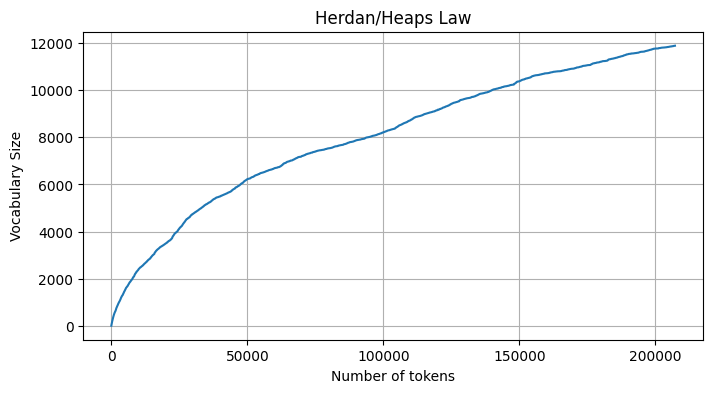

In [9]:
unique_word_counts = []
seen_words = set()
for token in tokens:
    seen_words.add(token)
    unique_word_counts.append(len(seen_words))

# Plotting Herdan/Heaps Law
plt.figure(figsize=(8, 4))
plt.plot(range(1, number_tokens + 1), unique_word_counts, label="Unique Words")
plt.xlabel("Number of tokens")
plt.ylabel("Vocabulary Size")
plt.title("Herdan/Heaps Law")
plt.grid(True)
plt.show()

Our dataset has the expected behaviour which expresses that the vocabulary size grows as we increase the number of tokens. Thus, we can never construct a dictionary with all the existent words.

We can try now to calculate the $k$ and $\beta$ coefficients from the Herdan/Heaps law that is expressed as:

$$ |V| = k N^{\beta}$$

In [10]:
log_total_words = np.log(range(1, number_tokens + 1)).reshape(-1, 1)
log_unique_word_counts = np.log(unique_word_counts).reshape(-1, 1)

regressor_heaps = LinearRegression()
regressor_heaps.fit(log_total_words, log_unique_word_counts)

beta = regressor_heaps.coef_[0][0]
k = np.exp(regressor_heaps.intercept_[0])

In [11]:
print(f"The coefficients are: \u03b2 = {beta} and k = {k}")

The coefficients are: β = 0.5613047369896365 and k = 13.133199867437984


This coincides with the typical ranges of k and $\beta$. These ranges are $k \in [10, 100]$ and  $\beta \in [0.4, 0.75]$. Therefore, the Herdan/Heaps law fullfills for our textual data.

### Zipf/Mandelbrot Law

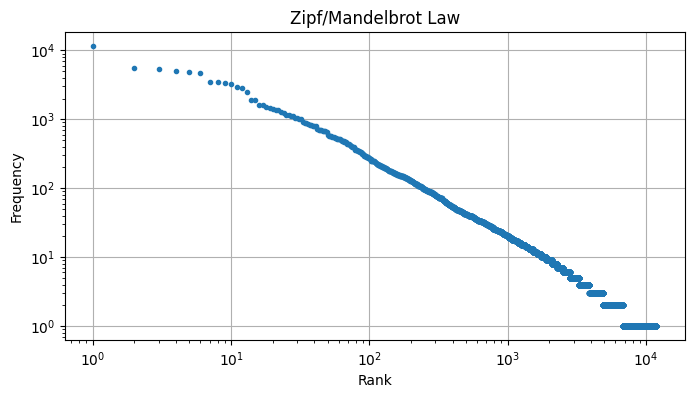

In [12]:
token_counts = Counter(tokens)
sorted_word_counts = sorted(token_counts.values(), reverse=True)

ranks = np.arange(1, len(sorted_word_counts) + 1)

plt.figure(figsize=(8, 4))
plt.loglog(ranks, sorted_word_counts, marker=".", linestyle="none")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.title("Zipf/Mandelbrot Law")
plt.grid(True)
plt.show()

Observe that the graph Zipf/Mandelbrot plot shows a linear behaviour in the logarithmic scale which corresponds to a power law. This tell us that there are a few words that are very frequent and there is a long tail of rare words.

We can try to calculate the parameters of the Zipf/Maldelbrot law which can be expressed as:

$$ f(r) = \frac{C}{(r + \beta)^{\alpha}}$$

In [13]:
def zipf_mandelbrot(rank, alpha, beta, C):
    log_freq = np.log(C) - alpha * np.log(rank + beta)
    return log_freq

log_frequencies = np.log(sorted_word_counts)

initial_guess = [1.0, 2.7, 10000]

popt, pcov = curve_fit(zipf_mandelbrot, ranks, log_frequencies, p0=initial_guess)
alpha, beta, C = popt

<ipython-input-13-968234dedcb4>:2: RuntimeWarning: invalid value encountered in log
  log_freq = np.log(C) - alpha * np.log(rank + beta)


In [14]:
print(f'Zipf/Mandelbrot Law coefficients: \u03b1 = {alpha}, \u03b2 = {beta}, C = {C}')

Zipf/Mandelbrot Law coefficients: α = 1.317714612822909, β = 18.685858363243586, C = 178562.6846345232


In the Zipf Mandelbrot law the coefficients we should expect are $\alpha \simeq 1$ and $\beta \simeq 2.7$. In our case, the $\alpha$ parameter is correct since we got a 1.31 value but in the case of $\beta$ we larger that we expected. This could be due to having a very large number of items with very low frequencies which can increase the $beta$ value.

## Text Preprocessing

### Loading the Data

We load the 4 Sherlock Holmes books using the TextLoader object.

In [15]:

study_scarlet_loader = TextLoader("./data/a_study_in_scarlet.txt")
sign_four_loader = TextLoader("./data/the_sign_of_the_four.txt")
hound_baskervilles_loader = TextLoader("./data/the_hound_of_the_baskervilles.txt")
valley_fear_loader = TextLoader("./data/the_valley_of_fear.txt")

study_scarlet = study_scarlet_loader.load()
sign_four = sign_four_loader.load()
hound_baskervilles = hound_baskervilles_loader.load()
valley_fear = valley_fear_loader.load()


### Text Splitter

We split the text using the RecursiveCharacterTextSplitter function which is the standard way to procede when dealing with generic text data. This is done in order to split a long document into smaller chunks that can fit into the model's context window.

This splitter works by prioritizing generic delimiters such as "\n\n", "\n", " " and "". This has the effect of trying to keep all paragraphs (and then sentences, and then words) together as long as possible, as those would generically seem to be the strongest semantically related pieces of text.

In [16]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000, # max chunk size
    chunk_overlap = 200, # overlap between consecutive chunks to ensure context is preserved
    length_function = len,)

In [17]:
study_scarlet_documents = text_splitter.transform_documents(study_scarlet)
sign_four_documents = text_splitter.transform_documents(sign_four)
hound_baskervilles_documents = text_splitter.transform_documents(hound_baskervilles)
valley_fear_documents = text_splitter.transform_documents(valley_fear)

In [18]:
print(len(study_scarlet_documents))
print(len(sign_four_documents))
print(len(hound_baskervilles_documents))
print(len(valley_fear_documents))

343
331
446
426


Now we join the 4 documents.

In [19]:
combined_documents = study_scarlet_documents + sign_four_documents + hound_baskervilles_documents + valley_fear_documents

## Vector Store

In order to store and search over textual data we need to embed it and then store the resulting embedding vectors. While performing the query this one will also be embedded so we can retrieve those vectors that are most similar to the query. A vector store then will be responsible to keep the embedded data and perform a similarity search given the query.

<img src="https://python.langchain.com/v0.1/assets/images/vector_stores-125d1675d58cfb46ce9054c9019fea72.jpg" alt="Vector Store">

To perform the retrieval of documents we use FAISS (Facebook AI Similarity Search), a library that allows to quickly search for embeddings of documents that are similar to each other.

In [20]:
def vector_store(store, embed_model_id, documents):

  core_embeddings_model = HuggingFaceEmbeddings(
    model_name=embed_model_id) # loads the specified embedding model

  embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings_model, store, namespace=embed_model_id)
  # intializes the embedder specifying the model, where to store it and the namespace

  vector_store = FAISS.from_documents(documents, embedder)  # Use modified_documents

  return vector_store, embedder, core_embeddings_model

# Embedding Model

We need to select an embedded model to store our textual data for future retrievals. This is not a trivial decision as the performance of our model can vary depending on the embedding model we select.

- sentence-transformers/all-MiniLM-L12-v2
- sentence-transformers/all-mpnet-base-v2
- sentence-transformers/multi-qa-MiniLM-L6-cos-v1

In [21]:
store = LocalFileStore("./cache/")
# initializes a storage intended to manage cached or stored data locally

embed_model_id_miniLM = 'sentence-transformers/all-MiniLM-L12-v2' # pre-trained specific embedding model
embed_model_id_mpnet = 'sentence-transformers/all-mpnet-base-v2'
embed_model_id_multi = 'sentence-transformers/multi-qa-MiniLM-L6-cos-v1'

vec_sto_miniLM, emb_miniLM, emb_mod_miniLM = vector_store(store=store, embed_model_id=embed_model_id_miniLM, documents=combined_documents)
vec_sto_mpnet, emb_mpnet, emb_mod_mpnet = vector_store(store=store, embed_model_id=embed_model_id_mpnet, documents=combined_documents)
vec_sto_multi, emb_multi, emb_mod_multi = vector_store(store=store, embed_model_id=embed_model_id_multi, documents=combined_documents)



<ipython-input-20-8951622dc3f7>:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  core_embeddings_model = HuggingFaceEmbeddings(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:90: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib

.gitattributes:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/134M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'cached_download' (from 'huggingface_hub.file_download') is deprecated and will be removed from version '0.26'. Use `hf_hub_download` instead.
  warnings.warn(warning_message, FutureWarning)


.gitattributes:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/791 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.8k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

Once we have the embeddings for the three models we can perform similarity search using a query which will be embedded and used to find the most similar documents in a vector store. The metric used is the similarity search by vector. We will perform 3 different queries and see the similarity score between the embedded query and the most similar document in the vector store.

In [ ]:
def return_similar_documents(vector_store, query, embed_model, k):

  embedding_vector = embed_model.embed_query(query)

  docs = vector_store.similarity_search_with_score_by_vector(embedding_vector, k=k)

  return docs

In [ ]:
query= "Who is Doctor Watson?"

docs_watson_miniLM = return_similar_documents(vector_store=vec_sto_miniLM, query=query, embed_model=emb_mod_miniLM, k=4)
docs_watson_mpnet = return_similar_documents(vector_store=vec_sto_mpnet, query=query, embed_model=emb_mod_mpnet, k=4)
docs_watson_multi = return_similar_documents(vector_store=vec_sto_multi, query=query, embed_model=emb_mod_multi, k=4)

query="How does Sherlock holmes makes deductions"

docs_deductions_miniLM = return_similar_documents(vector_store=vec_sto_miniLM, query=query, embed_model=emb_mod_miniLM, k=4)
docs_deductions_mpnet = return_similar_documents(vector_store=vec_sto_mpnet, query=query, embed_model=emb_mod_mpnet, k=4)
docs_deductions_multi = return_similar_documents(vector_store=vec_sto_multi, query=query, embed_model=emb_mod_multi, k=4)

query= "Who was really the Hound of the Baskervilles?"

docs_hound_miniLM = return_similar_documents(vector_store=vec_sto_miniLM, query=query, embed_model=emb_mod_miniLM, k=4)
docs_hound_mpnet = return_similar_documents(vector_store=vec_sto_mpnet, query=query, embed_model=emb_mod_mpnet, k=4)
docs_hound_multi = return_similar_documents(vector_store=vec_sto_multi, query=query, embed_model=emb_mod_multi, k=4)



In [ ]:
def visualize_similarity_score(docs, embedding_models, query):

  similarity_score = {}

  for i in range(len(docs)):
    scores = []
    for page in docs[i]:
      scores.append(page[1])
    similarity_score[embedding_models[i]] = scores

  means = {model: np.mean(scores) for model, scores in similarity_score.items()}
  std_devs = {model: np.std(scores) for model, scores in similarity_score.items()}

  plt.figure(figsize=(6, 4))
  plt.bar(means.keys(), means.values(), yerr=std_devs.values(), capsize=5, color='navy', alpha=0.7)
  plt.xlabel('Model')
  plt.ylabel('Similarity Mean Score')
  plt.title(f'{query}')
  plt.xticks(rotation=45)
  plt.show()



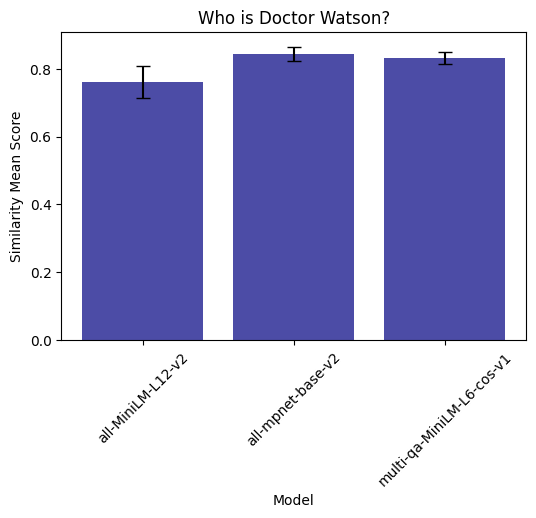

In [ ]:
embedding_models = ["all-MiniLM-L12-v2", "all-mpnet-base-v2", "multi-qa-MiniLM-L6-cos-v1"]
docs = [docs_watson_miniLM, docs_watson_mpnet, docs_watson_multi]
query = "Who is Doctor Watson?"

visualize_similarity_score(docs=docs, embedding_models=embedding_models, query=query)

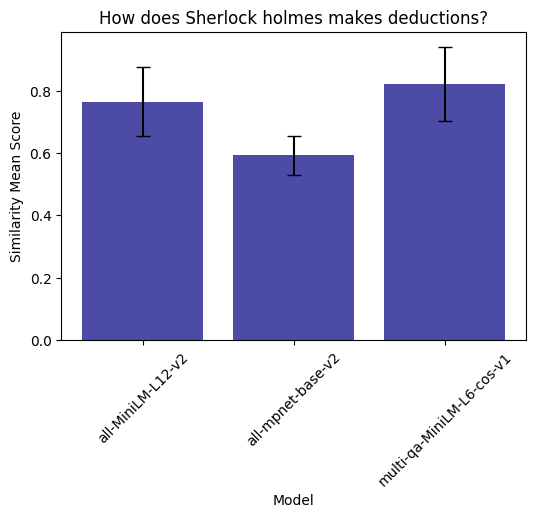

In [ ]:
docs = [docs_deductions_miniLM, docs_deductions_mpnet, docs_deductions_multi]
query = "How does Sherlock holmes makes deductions?"

visualize_similarity_score(docs=docs, embedding_models=embedding_models, query=query)

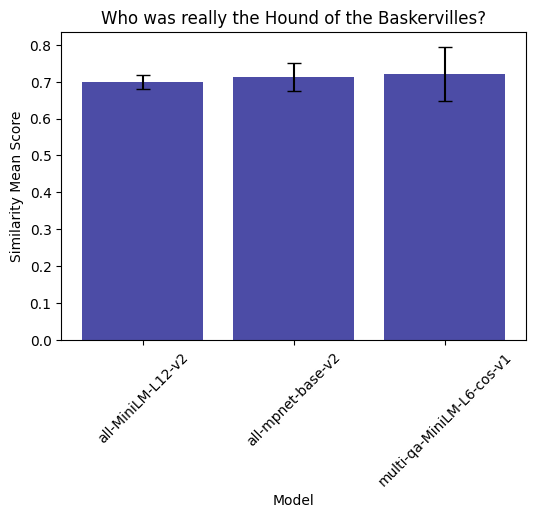

In [ ]:
docs = [docs_hound_miniLM, docs_hound_mpnet, docs_hound_multi]
query = "Who was really the Hound of the Baskervilles?"

visualize_similarity_score(docs=docs, embedding_models=embedding_models, query=query)

We can consider that the multi-qa-MiniLM-L6-cos-v1 is the embedding model that generally performs better considering the three queries all together. We can now asses that by giving the best similarity score document for the three answers for this model.

In [ ]:
docs_watson_multi[-1][0].page_content

'“does dr. watson live here?” asked a clear but rather harsh voice. we\ncould not hear the servant’s reply, but the door closed, and some one\nbegan to ascend the stairs. the footfall was an uncertain and shuffling\none. a look of surprise passed over the face of my companion as he\nlistened to it. it came slowly along the passage, and there was a feeble\ntap at the door.\n\n“come in,” i cried.\n\nat my summons, instead of the man of violence whom we expected, a very\nold and wrinkled woman hobbled into the apartment. she appeared to be\ndazzled by the sudden blaze of light, and after dropping a curtsey, she\nstood blinking at us with her bleared eyes and fumbling in her pocket\nwith nervous, shaky fingers. i glanced at my companion, and his face\nhad assumed such a disconsolate expression that it was all i could do to\nkeep my countenance.'

In [ ]:
docs_deductions_multi[-1][0].page_content

'chapter i\nthe science of deduction\n\n\nsherlock holmes took his bottle from the corner of the mantel-piece and\nhis hypodermic syringe from its neat morocco case. with his long,\nwhite, nervous fingers he adjusted the delicate needle, and rolled back\nhis left shirt-cuff. for some little time his eyes rested thoughtfully\nupon the sinewy forearm and wrist all dotted and scarred with\ninnumerable puncture-marks. finally he thrust the sharp point home,\npressed down the tiny piston, and sank back into the velvet-lined\narm-chair with a long sigh of satisfaction.'

In [ ]:
docs_hound_multi[-1][0].page_content

'with a curious lisping accent. i have myself seen this old man\n cross the grimpen mire by the path which stapleton had marked\n out. it is very probable, therefore, that in the absence of his\n master it was he who cared for the hound, though he may never\n have known the purpose for which the beast was used.'

# Retrieval Chain

Now that we have set the embedding model to use, the next step is to build a retrieval chain which will allow us to perform semantic questions to the data.

The LLM we choose is the Llama-2-7b-chat-hf which is a large language model with 7 billion parameters.

In [ ]:

model_id = "meta-llama/Llama-2-7b-chat-hf"

bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

model_config = transformers.AutoConfig.from_pretrained(
    model_id
)

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    config=model_config,
    quantization_config=bnb_config,
    device_map='auto'
)

model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )


The code sets up a transformer model using 4-bit quantization for efficient inference. It configures the model to use nf4 quantization, double quantization, and bfloat16 computation, loads the model configuration from a pre-trained model identifier, and ensures the model is distributed across available devices. Finally, it puts the model into evaluation mode, ready for inference tasks. This approach significantly reduces the memory footprint and can speed up inference while maintaining reasonable accuracy.

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_id
)

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

We then create our tokenizer object

In [ ]:
generate_text = transformers.pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    return_full_text=True,
    temperature=0.0,
    max_new_tokens=256
)

In [ ]:
llm = HuggingFacePipeline(pipeline=generate_text)

Then we initialize a text generation pipeline using the pre-trained model and tokenizer. The pipeline is set up to perform text generation with specific temperature and max amount of tokens

In [ ]:
retriever = vec_sto_multi.as_retriever()

In [ ]:
handler = StdOutCallbackHandler()

qa_with_sources_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    callbacks=[handler],
    return_source_documents=True
)

Finally, we get the final RAG model which will be able to answer to queries.

# Prompt Engineering

Prompt engineering consist in involves crafting specific, prompts to guide the LLMs generative task. In our case we, will use 5 questions to asses differents aspects of the model. These aspects are:

- Description of the main character.
- Understanding of the plot.
- Contextual retrieval.
- Generative Ability.
- Analysis


In [ ]:
def prompt_engineering(qa_with_sources_chain, embed_model, vector_store):

  """This function is used to perform prompt engeneering. This means to asses which
  are the most precise prompts that we can use to evaluate the impact of different models,
  parameters, embeddings, etc. Basically, is a try and error process in which we refine
  our prompts given the answers provided."""

  stop = False

  while not stop:

    query = input("Please provide a question: \n")

    embedding_vector = embed_model.embed_query(query)
    docs = vector_store.similarity_search_by_vector(embedding_vector, k=4)

    result = qa_with_sources_chain({"query": query})

    print(result['result'])
    print("/n")

    keep_going = input("Do you have another question? (Y/N)").strip().lower()

    if keep_going == "n":
      print("Thank you for your time")
      stop = True






In [ ]:
prompt_engineering(embed_model=emb_mod_multi,
                 vector_store=vec_sto_multi,
                 qa_with_sources_chain=qa_with_sources_chain)

Please provide a question: 
What is the main mistery in the Hound of the Baskervilles describe how this mistery turns


> Entering new RetrievalQA chain...


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(



> Finished chain.
Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

cover 



the hound of the baskervilles

another adventure of sherlock holmes


by a. conan doyle




my dear robinson,


 it was to your account of a west-country legend that this tale owes its
inception. for this and for your help in the details all thanks.



yours most truly, 

a. conan doyle. 



hindhead,

 haslemere.



contents


 chapter 1 mr. sherlock holmes
 chapter 2 the curse of the baskervilles
 chapter 3 the problem
 chapter 4 sir henry baskerville
 chapter 5 three broken threads
 chapter 6 baskerville hall
 chapter 7 the stapletons of merripit house
 chapter 8 first report of dr. watson
 chapter 9 the light upon the moor [second report of dr. watson]
 chapter 10 extract from the diary of dr. watson
 chapter 11 the man on the tor
 chapter 12 death on the moor
 chapter 13 fixing the nets
 cha

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(



> Finished chain.
Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

cover 



the hound of the baskervilles

another adventure of sherlock holmes


by a. conan doyle




my dear robinson,


 it was to your account of a west-country legend that this tale owes its
inception. for this and for your help in the details all thanks.



yours most truly, 

a. conan doyle. 



hindhead,

 haslemere.



contents


 chapter 1 mr. sherlock holmes
 chapter 2 the curse of the baskervilles
 chapter 3 the problem
 chapter 4 sir henry baskerville
 chapter 5 three broken threads
 chapter 6 baskerville hall
 chapter 7 the stapletons of merripit house
 chapter 8 first report of dr. watson
 chapter 9 the light upon the moor [second report of dr. watson]
 chapter 10 extract from the diary of dr. watson
 chapter 11 the man on the tor
 chapter 12 death on the moor
 chapter 13 fixing the nets
 cha

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(



> Finished chain.
Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

cover 



the hound of the baskervilles

another adventure of sherlock holmes


by a. conan doyle




my dear robinson,


 it was to your account of a west-country legend that this tale owes its
inception. for this and for your help in the details all thanks.



yours most truly, 

a. conan doyle. 



hindhead,

 haslemere.



contents


 chapter 1 mr. sherlock holmes
 chapter 2 the curse of the baskervilles
 chapter 3 the problem
 chapter 4 sir henry baskerville
 chapter 5 three broken threads
 chapter 6 baskerville hall
 chapter 7 the stapletons of merripit house
 chapter 8 first report of dr. watson
 chapter 9 the light upon the moor [second report of dr. watson]
 chapter 10 extract from the diary of dr. watson
 chapter 11 the man on the tor
 chapter 12 death on the moor
 chapter 13 fixing the nets
 cha

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(



> Finished chain.
Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

cover 



the hound of the baskervilles

another adventure of sherlock holmes


by a. conan doyle




my dear robinson,


 it was to your account of a west-country legend that this tale owes its
inception. for this and for your help in the details all thanks.



yours most truly, 

a. conan doyle. 



hindhead,

 haslemere.



contents


 chapter 1 mr. sherlock holmes
 chapter 2 the curse of the baskervilles
 chapter 3 the problem
 chapter 4 sir henry baskerville
 chapter 5 three broken threads
 chapter 6 baskerville hall
 chapter 7 the stapletons of merripit house
 chapter 8 first report of dr. watson
 chapter 9 the light upon the moor [second report of dr. watson]
 chapter 10 extract from the diary of dr. watson
 chapter 11 the man on the tor
 chapter 12 death on the moor
 chapter 13 fixing the nets
 cha

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(



> Finished chain.
Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

cover 



the hound of the baskervilles

another adventure of sherlock holmes


by a. conan doyle




my dear robinson,


 it was to your account of a west-country legend that this tale owes its
inception. for this and for your help in the details all thanks.



yours most truly, 

a. conan doyle. 



hindhead,

 haslemere.



contents


 chapter 1 mr. sherlock holmes
 chapter 2 the curse of the baskervilles
 chapter 3 the problem
 chapter 4 sir henry baskerville
 chapter 5 three broken threads
 chapter 6 baskerville hall
 chapter 7 the stapletons of merripit house
 chapter 8 first report of dr. watson
 chapter 9 the light upon the moor [second report of dr. watson]
 chapter 10 extract from the diary of dr. watson
 chapter 11 the man on the tor
 chapter 12 death on the moor
 chapter 13 fixing the nets
 cha

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(



> Finished chain.
Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

cover 



the hound of the baskervilles

another adventure of sherlock holmes


by a. conan doyle




my dear robinson,


 it was to your account of a west-country legend that this tale owes its
inception. for this and for your help in the details all thanks.



yours most truly, 

a. conan doyle. 



hindhead,

 haslemere.



contents


 chapter 1 mr. sherlock holmes
 chapter 2 the curse of the baskervilles
 chapter 3 the problem
 chapter 4 sir henry baskerville
 chapter 5 three broken threads
 chapter 6 baskerville hall
 chapter 7 the stapletons of merripit house
 chapter 8 first report of dr. watson
 chapter 9 the light upon the moor [second report of dr. watson]
 chapter 10 extract from the diary of dr. watson
 chapter 11 the man on the tor
 chapter 12 death on the moor
 chapter 13 fixing the nets
 cha

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(



> Finished chain.
Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

cover 



the hound of the baskervilles

another adventure of sherlock holmes


by a. conan doyle




my dear robinson,


 it was to your account of a west-country legend that this tale owes its
inception. for this and for your help in the details all thanks.



yours most truly, 

a. conan doyle. 



hindhead,

 haslemere.



contents


 chapter 1 mr. sherlock holmes
 chapter 2 the curse of the baskervilles
 chapter 3 the problem
 chapter 4 sir henry baskerville
 chapter 5 three broken threads
 chapter 6 baskerville hall
 chapter 7 the stapletons of merripit house
 chapter 8 first report of dr. watson
 chapter 9 the light upon the moor [second report of dr. watson]
 chapter 10 extract from the diary of dr. watson
 chapter 11 the man on the tor
 chapter 12 death on the moor
 chapter 13 fixing the nets
 cha

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(



> Finished chain.
Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

cover 



the hound of the baskervilles

another adventure of sherlock holmes


by a. conan doyle




my dear robinson,


 it was to your account of a west-country legend that this tale owes its
inception. for this and for your help in the details all thanks.



yours most truly, 

a. conan doyle. 



hindhead,

 haslemere.



contents


 chapter 1 mr. sherlock holmes
 chapter 2 the curse of the baskervilles
 chapter 3 the problem
 chapter 4 sir henry baskerville
 chapter 5 three broken threads
 chapter 6 baskerville hall
 chapter 7 the stapletons of merripit house
 chapter 8 first report of dr. watson
 chapter 9 the light upon the moor [second report of dr. watson]
 chapter 10 extract from the diary of dr. watson
 chapter 11 the man on the tor
 chapter 12 death on the moor
 chapter 13 fixing the nets
 cha

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(



> Finished chain.
Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

"a touch! a distinct touch!" cried holmes. "you are developing a
certain unexpected vein of pawky humour, watson, against which i must
learn to guard myself. but in calling moriarty a criminal you are
uttering libel in the eyes of the law--and there lie the glory and the
wonder of it! the greatest schemer of all time, the organizer of every
deviltry, the controlling brain of the underworld, a brain which might
have made or marred the destiny of nations--that's the man! but so
aloof is he from general suspicion, so immune from criticism, so
admirable in his management and self-effacement, that for those very
words that you have uttered he could hale you to a court and emerge
with your year's pension as a solatium for his wounded character. is he
not the celebrated author of the dynamics of an asteroid, a bo

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(



> Finished chain.
Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

chapter iii
in quest of a solution


it was half-past five before holmes returned. he was bright, eager, and
in excellent spirits,—a mood which in his case alternated with fits of
the blackest depression.

“there is no great mystery in this matter,” he said, taking the cup of
tea which i had poured out for him. “the facts appear to admit of only
one explanation.”

“what! you have solved it already?”

“well, that would be too much to say. i have discovered a suggestive
fact, that is all. it is, however, _very_ suggestive. the details are
still to be added. i have just found, on consulting the back files of
the _times_, that major sholto, of upper norword, late of the 34th
bombay infantry, died upon the 28th of april, 1882.”

“i may be very obtuse, holmes, but i fail to see what this suggests.”

ready to his

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(



> Finished chain.
Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

sherlock holmes--his limits.

 1. knowledge of literature.--nil.
 2. philosophy.--nil.
 3. astronomy.--nil.
 4. politics.--feeble.
 5. botany.--variable. well up in belladonna,
 opium, and poisons generally.
 knows nothing of practical gardening.
 6. geology.--practical, but limited.
 tells at a glance different soils
 from each other. after walks has
 shown me splashes upon his trousers,
 and told me by their colour and
 consistence in what part of london
 he had received them.
 7. chemistry.--profound.
 8. anatomy.--accurate, but unsystematic.
 9. sensational literature.--immense. he appears
 to know every detail of every horror
 perpetrated in the century.
 10. plays the violin well.
 11. is an expert singlestick player, boxer, and swordsman.
 12. has a good practical knowledge of british law.

i had im

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(



> Finished chain.
Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

“well, that is what we have to find out.”

 “whichever it is, my answer is fixed. there is no devil in hell,
 mr. holmes, and there is no man upon earth who can prevent me
 from going to the home of my own people, and you may take that to
 be my final answer.” his dark brows knitted and his face flushed
 to a dusky red as he spoke. it was evident that the fiery temper
 of the baskervilles was not extinct in this their last
 representative. “meanwhile,” said he, “i have hardly had time to
 think over all that you have told me. it’s a big thing for a man
 to have to understand and to decide at one sitting. i should like
 to have a quiet hour by myself to make up my mind. now, look
 here, mr. holmes, it’s half-past eleven now and i am going back
 right away to my hotel. suppose you and your friend, dr. watson

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(



> Finished chain.
Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

“let holmes know all about it at once. it will give him the clue
 for which he has been seeking. i am much mistaken if it does not
 bring him down.”

 i went at once to my room and drew up my report of the morning’s
 conversation for holmes. it was evident to me that he had been
 very busy of late, for the notes which i had from baker street
 were few and short, with no comments upon the information which i
 had supplied and hardly any reference to my mission. no doubt his
 blackmailing case is absorbing all his faculties. and yet this
 new factor must surely arrest his attention and renew his
 interest. i wish that he were here.

“your statement is most interesting,” said sherlock holmes. “has
anything else occurred to you?”

“yes, and no later than to-day. that is why i have come to you. this
morning i r

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(



> Finished chain.
Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

“let holmes know all about it at once. it will give him the clue
 for which he has been seeking. i am much mistaken if it does not
 bring him down.”

 i went at once to my room and drew up my report of the morning’s
 conversation for holmes. it was evident to me that he had been
 very busy of late, for the notes which i had from baker street
 were few and short, with no comments upon the information which i
 had supplied and hardly any reference to my mission. no doubt his
 blackmailing case is absorbing all his faculties. and yet this
 new factor must surely arrest his attention and renew his
 interest. i wish that he were here.

“your statement is most interesting,” said sherlock holmes. “has
anything else occurred to you?”

“yes, and no later than to-day. that is why i have come to you. this
morning i r

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(



> Finished chain.
Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

he had spoken in jesting vein, but the twitching of his bushy eyebrows
bespoke his disappointment and irritation. i sat helpless and unhappy,
staring into the fire. a long silence was broken by a sudden
exclamation from holmes, who dashed at a cupboard, from which he
emerged with a second yellow-covered volume in his hand.

“let holmes know all about it at once. it will give him the clue
 for which he has been seeking. i am much mistaken if it does not
 bring him down.”

 i went at once to my room and drew up my report of the morning’s
 conversation for holmes. it was evident to me that he had been
 very busy of late, for the notes which i had from baker street
 were few and short, with no comments upon the information which i
 had supplied and hardly any reference to my mission. no doubt his
 blackmailing

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(



> Finished chain.
Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

i saw holmes put his hand to his forehead like a man distracted.
 he stamped his feet upon the ground.

 “he has beaten us, watson. we are too late.”

 “no, no, surely not!”

 “fool that i was to hold my hand. and you, watson, see what comes
 of abandoning your charge! but, by heaven, if the worst has
 happened we’ll avenge him!”

 blindly we ran through the gloom, blundering against boulders,
 forcing our way through gorse bushes, panting up hills and
 rushing down slopes, heading always in the direction whence those
 dreadful sounds had come. at every rise holmes looked eagerly
 round him, but the shadows were thick upon the moor, and nothing
 moved upon its dreary face.

 “can you see anything?”

 “nothing.”

 “but, hark, what is that?”

“a presentation, i see,” said holmes.

 “yes, sir.”

 “from charin

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(



> Finished chain.
Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

our pace, the fog, and my own limited knowledge of london, i lost my
bearings, and knew nothing, save that we seemed to be going a very long
way. sherlock holmes was never at fault, however, and he muttered the
names as the cab rattled through squares and in and out by tortuous
by-streets.

sherlock holmes--his limits.

 1. knowledge of literature.--nil.
 2. philosophy.--nil.
 3. astronomy.--nil.
 4. politics.--feeble.
 5. botany.--variable. well up in belladonna,
 opium, and poisons generally.
 knows nothing of practical gardening.
 6. geology.--practical, but limited.
 tells at a glance different soils
 from each other. after walks has
 shown me splashes upon his trousers,
 and told me by their colour and
 consistence in what part of london
 he had received them.
 7. chemistry.--profound.
 8. anatomy.--a

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(



> Finished chain.
Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

sherlock holmes--his limits.

 1. knowledge of literature.--nil.
 2. philosophy.--nil.
 3. astronomy.--nil.
 4. politics.--feeble.
 5. botany.--variable. well up in belladonna,
 opium, and poisons generally.
 knows nothing of practical gardening.
 6. geology.--practical, but limited.
 tells at a glance different soils
 from each other. after walks has
 shown me splashes upon his trousers,
 and told me by their colour and
 consistence in what part of london
 he had received them.
 7. chemistry.--profound.
 8. anatomy.--accurate, but unsystematic.
 9. sensational literature.--immense. he appears
 to know every detail of every horror
 perpetrated in the century.
 10. plays the violin well.
 11. is an expert singlestick player, boxer, and swordsman.
 12. has a good practical knowledge of british law.

our pace

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(



> Finished chain.
Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

sherlock holmes--his limits.

 1. knowledge of literature.--nil.
 2. philosophy.--nil.
 3. astronomy.--nil.
 4. politics.--feeble.
 5. botany.--variable. well up in belladonna,
 opium, and poisons generally.
 knows nothing of practical gardening.
 6. geology.--practical, but limited.
 tells at a glance different soils
 from each other. after walks has
 shown me splashes upon his trousers,
 and told me by their colour and
 consistence in what part of london
 he had received them.
 7. chemistry.--profound.
 8. anatomy.--accurate, but unsystematic.
 9. sensational literature.--immense. he appears
 to know every detail of every horror
 perpetrated in the century.
 10. plays the violin well.
 11. is an expert singlestick player, boxer, and swordsman.
 12. has a good practical knowledge of british law.

chapter 

### Result of Prompt Engineering

The task we specified before are evaluated with the following questions. Each question is a try and error product in which we have refined our prompts considering the outputs given.

\

Question 1: Provide a detailed description of Sherlock Holmes, incorporating his appearance and character traits. Highlight key physical features, personality traits, and examples of Holmes extravagances and social interactions.

To arrive to this prompt we started with just the prompt of describe Sherlock Holmes in detail. As it provided a too vague description we tried to go into more details highlighting what makes SHerlock special such as his character, extravagances and lack of social abilities in some cases.

\

Question 2: Understanding of the plot. What is the main mistery in the Hound of the Baskervilles. Briefly explain the truth behind it. Do not get into the details.

In this question we tried to make generate text to prove that it can summarizes and understands part of the plot of a book. We choose the Hound of the Baskervilles and the mistery about the Baskerville family damnation and the hund. In this prompt we had to indicate to be brief and not go into the details as otherwise it will provide a too large explanation of it.

\

Question 3: Examine the signature investigative methods of Sherlock Holmes in deducing and solving complex cases.

First we tried to apply how Sherlock solves cases to an example but the problem with that is that it went too much into the detail of that case. Instead we have gone more general tweeking some words to give the result of the final prompt. The result gives us the text into a set of bullet points.

\

Question 4: Generate a dialogue between Dr. Watson and Holmes discussing a new case presented to them.

Regarding this question, we started with Dr Watson and Holmes discussing a case presented to them but this end up recreating the Hound of the Baskervilles case. So we introduced the keyword new. The prompt results in a surprisingly believable dialogue of Holmes and Watson discussing a new case.

\

Question 5: Analyze the significance of London as a setting in the Sherlock Holmes stories. Using 'A Study in Scarlet' as a primary reference, analyze how London serves as a way to reflect the complexities of Victorian society.

Finally, for the question 5 we started by just analyzing London in the Sherlock Holmes books. Since this described London for a too wide scope we try to restrict this to the information presented in the 'A Study in Scarlet' book as well to focus mainly in how the complexities of the Victorian society are described (inequalities, industrial transformation, etc).

### Temperature

We have tried to see what is the model response to a change in the temperature parameter. Recall that a higher temperatures implies more diverse and exploratory generation while a lower one results in a more deterministic and conservative generation. In our case though, the temperature parameter doesn't change the output of the model. This could be due to having quite a small dataset for the RAG application.

We have used 4 different values of temperature in which we get the same output (0.5, 1, 2.5, 5). In order to not be repetitive, we perform the text generation just once for the case with temperature=1.

In [ ]:
def get_helpful_answer(response):

  result = response.get('result', 'No result')

# Process the result to extract the Helpful Answer directly
  helpful_answer = None
  if 'Helpful Answer:' in result:
    helpful_answer = result.split('Helpful Answer:')[1].strip()

  print("Helpful Answer:", helpful_answer)

In [ ]:

def generate_text(temperature, model, vector_store, query):

  generate_text = transformers.pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    return_full_text=True,
    temperature=temperature,
    max_new_tokens=1000)

  llm = HuggingFacePipeline(pipeline=generate_text)

  retriever = vector_store.as_retriever()

  handler = StdOutCallbackHandler()

  qa_with_sources_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    callbacks=[handler],
    return_source_documents=True)

  result = qa_with_sources_chain({"query": query})

  return result



In [ ]:
query = "Provide a detailed description of Sherlock Holmes, \
incorporating his appearance and character traits. Highlight key physical features, \
 personality traits, and examples of Holmes extravagances and social interactions."

response = generate_text(temperature=1, model=model, vector_store=vec_sto_multi, query=query)

get_helpful_answer(response)



> Entering new RetrievalQA chain...

> Finished chain.
Helpful Answer: Sherlock Holmes is a tall, thin man with a hawk-like nose and piercing eyes. He has a gaunt face with sunken cheeks and a stern expression. He is often seen wearing a long, dark coat with a wide brimmed hat and a pair of thick, black-rimmed spectacles. Holmes is a highly intelligent and observant individual, with an encyclopedic knowledge of various subjects, including literature, philosophy, astronomy, politics, botany, geology, chemistry, anatomy, sensational literature, and plays the violin well. He is an expert singlestick player, boxer, and swordsman. Holmes has a good practical knowledge of British law. He is also known for his ability to detach his mind at will, and he often appears to be completely absorbed in his thoughts. Holmes is a socially awkward individual who is not very good at interacting with people, often appearing distant or aloof. He is also known for his eccentricities, such as his love of t

Helpful Answer: Sherlock Holmes is a tall, thin man with a hawk-like nose and piercing eyes. He has a gaunt face with sunken cheeks and a stern expression. He is often seen wearing a long, dark coat with a wide brimmed hat and a pair of thick, black-rimmed spectacles. Holmes is a highly intelligent and observant individual, with an encyclopedic knowledge of various subjects, including literature, philosophy, astronomy, politics, botany, geology, chemistry, anatomy, sensational literature, and plays the violin well. He is an expert singlestick player, boxer, and swordsman. Holmes has a good practical knowledge of British law. He is also known for his ability to detach his mind at will, and he often appears to be completely absorbed in his thoughts. Holmes is a socially awkward individual who is not very good at interacting with people, often appearing distant or aloof. He is also known for his eccentricities, such as his love of tobacco and his habit of keeping a pet rat.

In [ ]:
query = "What is the main mistery in the Hound of the Baskervilles. \
Briefly explain the truth behind it. Do not get into the details."

response = generate_text(temperature=1, model=model, vector_store=vec_sto_multi, query=query)

get_helpful_answer(response)




> Entering new RetrievalQA chain...

> Finished chain.
Helpful Answer: The main mystery in The Hound of the Baskervilles is the disappearance of Sir Charles Baskerville and the subsequent appearance of a giant hound that is believed to be a supernatural creature that haunts the Baskervilles. The truth behind the mystery is that Sir Charles was actually murdered by a man named Stapleton, who was trying to inherit the Baskerville estate. Stapleton had been working with his brother, who was the caretaker of Baskerville Hall, to carry out the murder and make it seem like the hound was responsible. However, the hound was not supernatural, but rather a trained dog that Stapleton had been using to terrorize the Baskervilles.


Helpful Answer: The main mystery in The Hound of the Baskervilles is the disappearance of Sir Charles Baskerville and the subsequent appearance of a giant hound that is believed to be a supernatural creature that haunts the Baskervilles. The truth behind the mystery is that Sir Charles was actually murdered by a man named Stapleton, who was trying to inherit the Baskerville estate. Stapleton had been working with his brother, who was the caretaker of Baskerville Hall, to carry out the murder and make it seem like the hound was responsible. However, the hound was not supernatural, but rather a trained dog that Stapleton had been using to terrorize the Baskervilles.

In [ ]:
query = "Examine the signature investigative methods of Sherlock Holmes in deducing and solving complex cases."

response = generate_text(temperature=1, model=model, vector_store=vec_sto_multi, query=query)

get_helpful_answer(response)




> Entering new RetrievalQA chain...

> Finished chain.
Helpful Answer: Sherlock Holmes's signature investigative methods include:

1. Observation: Holmes is known for his keen powers of observation, which he uses to gather information from his surroundings. He notices small details that others might overlook, which can lead to important clues.
2. Deduction: Holmes is skilled at drawing conclusions from the information he gathers through observation. He uses his knowledge of human behavior and psychology to make educated guesses about the motivations and actions of criminals.
3. Logical reasoning: Holmes is a master of logical reasoning, using his knowledge of criminal psychology and forensic science to piece together the facts of a case and build a convincing theory.
4. Pattern recognition: Holmes is skilled at recognizing patterns in data, which can help him identify connections between seemingly unrelated events.
5. Analogies: Holmes often uses analogies to help explain complex con

Helpful Answer: Sherlock Holmes's signature investigative methods include:

1. Observation: Holmes is known for his keen powers of observation, which he uses to gather information from his surroundings. He notices small details that others might overlook, which can lead to important clues.
2. Deduction: Holmes is skilled at drawing conclusions from the information he gathers through observation. He uses his knowledge of human behavior and psychology to make educated guesses about the motivations and actions of criminals.
3. Logical reasoning: Holmes is a master of logical reasoning, using his knowledge of criminal psychology and forensic science to piece together the facts of a case and build a convincing theory.
4. Pattern recognition: Holmes is skilled at recognizing patterns in data, which can help him identify connections between seemingly unrelated events.
5. Analogies: Holmes often uses analogies to help explain complex concepts or to make predictions about the actions of criminals.
6. Experimentation: Holmes is not afraid to conduct experiments or tests to gather additional evidence or to test his theories.
7. Collaboration: Holmes often works with other characters, such as Dr. Watson or Inspector Lestrade, to gather information and solve cases.
8. Persistence: Holmes is known for his unwavering persistence in solving cases, even when faced with seemingly insurmountable obstacles.

Note: These methods are not mutually exclusive, and Holmes often uses a combination of several methods to solve a case.

In [ ]:
query = "Generate a dialogue between Dr. Watson and Holmes discussing a new case presented to them."

response = generate_text(temperature=1, model=model, vector_store=vec_sto_multi, query=query)

get_helpful_answer(response)




> Entering new RetrievalQA chain...

> Finished chain.
Helpful Answer: Holmes and Watson engage in a conversation about a new case presented to them. Holmes is excited about the case and Watson is skeptical.

Holmes: "Watson, have you heard the latest? A most intriguing case has been presented to us!"

Watson: "Really, Holmes? And what might that be?"

Holmes: "A man has been murdered, and the most peculiar thing is that there is no sign of the killer anywhere!"

Watson: "Hmm, that does sound interesting. But I must admit, I'm not sure I'm convinced."

Holmes: "Ah, but that is where you are wrong, my dear Watson! The facts are crystal clear. The victim was killed with a weapon that left no trace, and yet, there is no sign of the killer anywhere. It's almost as if they vanished into thin air!"

Watson: "I see what you mean, Holmes. But don't you think it's a bit far-fetched?"

Holmes: "Far-fetched? Watson, this is the most fascinating


Helpful Answer: Holmes and Watson engage in a conversation about a new case presented to them. Holmes is excited about the case and Watson is skeptical.

Holmes: "Watson, have you heard the latest? A most intriguing case has been presented to us!"

Watson: "Really, Holmes? And what might that be?"

Holmes: "A man has been murdered, and the most peculiar thing is that there is no sign of the killer anywhere!"

Watson: "Hmm, that does sound interesting. But I must admit, I'm not sure I'm convinced."

Holmes: "Ah, but that is where you are wrong, my dear Watson! The facts are crystal clear. The victim was killed with a weapon that left no trace, and yet, there is no sign of the killer anywhere. It's almost as if they vanished into thin air!"

Watson: "I see what you mean, Holmes. But don't you think it's a bit far-fetched?"

Holmes: "Far-fetched? Watson, this is the most fascinating

In [ ]:
query = "Analyze the significance of London as a setting in the Sherlock Holmes stories. \
Using 'A Study in Scarlet' as a primary reference, analyze how London serves as a way to reflect the complexities of Victorian society."

response = generate_text(temperature=1, model=model, vector_store=vec_sto_multi, query=query)

get_helpful_answer(response)




> Entering new RetrievalQA chain...

> Finished chain.
Helpful Answer: In the Sherlock Holmes stories, London serves as a significant setting that reflects the complexities of Victorian society. In 'A Study in Scarlet,' London is portrayed as a bustling, crowded city that is both exciting and overwhelming. The city's foggy atmosphere and narrow streets create a sense of mystery and intrigue, which is fitting given the detective's line of work.

One way in which London reflects the complexities of Victorian society is through its representation of social class. The city is home to a diverse range of people, from the wealthy elite to the poor and marginalized. Holmes' own background, as a brilliant but socially awkward outsider, highlights the tensions between the upper and lower classes. The detective's ability to navigate these social hierarchies is a key aspect of his character and his detective work.

London also serves as a setting for the exploration of themes such as crime, just

Helpful Answer: In the Sherlock Holmes stories, London serves as a significant setting that reflects the complexities of Victorian society. In 'A Study in Scarlet,' London is portrayed as a bustling, crowded city that is both exciting and overwhelming. The city's foggy atmosphere and narrow streets create a sense of mystery and intrigue, which is fitting given the detective's line of work.

One way in which London reflects the complexities of Victorian society is through its representation of social class. The city is home to a diverse range of people, from the wealthy elite to the poor and marginalized. Holmes' own background, as a brilliant but socially awkward outsider, highlights the tensions between the upper and lower classes. The detective's ability to navigate these social hierarchies is a key aspect of his character and his detective work.

London also serves as a setting for the exploration of themes such as crime, justice, and morality. The city's criminal underworld is a major focus of the stories, with Holmes and Watson often dealing with cases involving theft, assault, and even murder.

### Different Embedding Models

Since now we have performed the text generation using the embedding model that previously gave us a better mean similarity score. Let's now try to see how the performance of the model changes using the other two embeddings.

### all-MiniLM-L12-v2


In [ ]:
query = "Provide a detailed description of Sherlock Holmes, \
incorporating his appearance and character traits. Highlight key physical features, \
 personality traits, and examples of Holmes extravagances and social interactions."

response = generate_text(temperature=1, model=model, vector_store=vec_sto_miniLM, query=query)

get_helpful_answer(response)



> Entering new RetrievalQA chain...

> Finished chain.
Helpful Answer: Sherlock Holmes is a tall, thin man with a black beard cut square at the end and a pale face. He dresses like a toff and has a middle age. He is of a middle height, two or three inches shorter than you, sir. He has a keen face bronzed by the sun and roughened by the wind. He is an expert singlestick player, boxer, and swordsman. He has a good practical knowledge of British law. He is not altogether such an easy gentleman to describe. He is irregular in his methods and a little quick perhaps in jumping at theories, but on the whole, he would have made a most promising officer. He is a man who is not to be beat.

Unhelpful Answer: I don't know, I don't have a detailed description of Sherlock Holmes. I don't know his appearance or personality traits. I don't know if he has any physical features or if he is tall or short. I don't know if he has a black beard or a pale face. I don't know if he dresses like a toff or if

Helpful Answer: Sherlock Holmes is a tall, thin man with a black beard cut square at the end and a pale face. He dresses like a toff and has a middle age. He is of a middle height, two or three inches shorter than you, sir. He has a keen face bronzed by the sun and roughened by the wind. He is an expert singlestick player, boxer, and swordsman. He has a good practical knowledge of British law. He is not altogether such an easy gentleman to describe. He is irregular in his methods and a little quick perhaps in jumping at theories, but on the whole, he would have made a most promising officer. He is a man who is not to be beat.

In [ ]:
query = "What is the main mistery in the Hound of the Baskervilles. \
Briefly explain the truth behind it. Do not get into the details."

response = generate_text(temperature=1, model=model, vector_store=vec_sto_miniLM, query=query)

get_helpful_answer(response)




> Entering new RetrievalQA chain...

> Finished chain.
Helpful Answer: The main mystery in The Hound of the Baskervilles is the death of Sir Charles Baskerville and the subsequent disappearance of his heir, Sir Henry Baskerville. The story revolves around the investigation of these events by Sherlock Holmes and Dr. Watson, who uncover the truth behind the legend of the Hound of the Baskervilles, a supernatural hound said to haunt the moors and kill anyone in the Baskerville family. The truth behind the mystery is that Sir Charles Baskerville was murdered by his nephew, Stapleton, who was trying to inherit the Baskerville estate. Stapleton had been manipulating the women in the story, Mrs. Stapleton and Mrs. Laura Lyons, to make it seem like the Hound of the Baskervilles was responsible for the death, while he carried out his plan. Holmes and Watson uncover the truth through their investigation and solve the mystery.


The main mystery in The Hound of the Baskervilles is the death of Sir Charles Baskerville and the subsequent disappearance of his heir, Sir Henry Baskerville. The story revolves around the investigation of these events by Sherlock Holmes and Dr. Watson, who uncover the truth behind the legend of the Hound of the Baskervilles, a supernatural hound said to haunt the moors and kill anyone in the Baskerville family. The truth behind the mystery is that Sir Charles Baskerville was murdered by his nephew, Stapleton, who was trying to inherit the Baskerville estate. Stapleton had been manipulating the women in the story, Mrs. Stapleton and Mrs. Laura Lyons, to make it seem like the Hound of the Baskervilles was responsible for the death, while he carried out his plan. Holmes and Watson uncover the truth through their investigation and solve the mystery.

In [ ]:
query = "Examine the signature investigative methods of Sherlock Holmes in deducing and solving complex cases."

response = generate_text(temperature=1, model=model, vector_store=vec_sto_miniLM, query=query)

get_helpful_answer(response)




> Entering new RetrievalQA chain...

> Finished chain.
Helpful Answer: Sherlock Holmes' signature investigative methods include:

1. Observation and Description: Holmes pays close attention to details and descriptions of people, places, and objects, often using his powers of observation to piece together seemingly unrelated clues.

2. Deduction and Logic: Holmes uses his vast knowledge of science, medicine, and philosophy to deduce conclusions from available evidence. He is skilled at using logic to connect seemingly unrelated facts and create a coherent picture of the case.

3. Hypothetical Scenarios: Holmes often creates hypothetical scenarios to test his theories and see how they hold up to different possibilities. This helps him to narrow down the list of potential suspects and motives.

4. Experimentation and Testing: Holmes is not afraid to experiment and test his theories through various means, such as conducting experiments or creating mock scenarios. This allows him to gathe

Helpful Answer: Sherlock Holmes' signature investigative methods include:

1. Observation and Description: Holmes pays close attention to details and descriptions of people, places, and objects, often using his powers of observation to piece together seemingly unrelated clues.

2. Deduction and Logic: Holmes uses his vast knowledge of science, medicine, and philosophy to deduce conclusions from available evidence. He is skilled at using logic to connect seemingly unrelated facts and create a coherent picture of the case.

3. Hypothetical Scenarios: Holmes often creates hypothetical scenarios to test his theories and see how they hold up to different possibilities. This helps him to narrow down the list of potential suspects and motives.

4. Experimentation and Testing: Holmes is not afraid to experiment and test his theories through various means, such as conducting experiments or creating mock scenarios. This allows him to gather more information and refine his theories.

5. Collaboration and Partnership: Holmes often works with other investigators, such as Lestrade and Gregson, to share information and insights. He also values the contributions of his trusted friend and partner, Dr. Watson, who provides a unique perspective on the case.

6. Analyzing Motives: Holmes is skilled at analyzing the motives of suspects and potential perpetrators, often using psychological insights to understand their actions and behaviors.

7. Focus on the Details: Holmes is known for his ability to focus on the smallest details, often overlooked by others. He believes that these details can hold the key to solving a case.

8. Use of Disguises: Holmes sometimes uses disguises to gather information or to get closer to a suspect without arousing suspicion.

9. Use of Technology: Holmes is not afraid to use technology, such as cameras, microscopes, and other scientific instruments, to gather evidence and analyze it.

10. Continuous Learning: Holmes is a lifelong learner, constantly updating his knowledge and skills to stay ahead of the game. He is always looking for new ways to improve his investigative methods and solve complex cases.

In [ ]:
query = "Generate a dialogue between Dr. Watson and Holmes discussing a new case presented to them."

response = generate_text(temperature=1, model=model, vector_store=vec_sto_miniLM, query=query)

get_helpful_answer(response)




> Entering new RetrievalQA chain...

> Finished chain.
Helpful Answer: Sure! Here is a dialogue between Dr. Watson and Sherlock Holmes discussing a new case presented to them:

Dr. Watson: "Holmes, have you found anything out?"

Sherlock Holmes: "Well, Watson, I say, would you be afraid to sleep in the same room with a lunatic, a man with softening of the brain, an idiot whose mind has lost its grip?"

Dr. Watson: "Not in the least," I answered in astonishment.

Sherlock Holmes: "Ah, that's lucky. Macdonald and White Mason are here to see us. They're on the track of the elusive bicyclist, and they're hoping you can help them."

Dr. Watson: "I see. What's the latest news of the ruffian?"

Inspector Macdonald: "Well, Dr. Watson, we've been investigating a series of burglaries in the area, and we believe the culprit may be in league with a local gang."

Sherlock Holmes: "Ah, an interesting development. I take it you've found some leads?"

Inspector Macdonald: "Yes, we have. We've discov

Helpful Answer: Sure! Here is a dialogue between Dr. Watson and Sherlock Holmes discussing a new case presented to them:

Dr. Watson: "Holmes, have you found anything out?"

Sherlock Holmes: "Well, Watson, I say, would you be afraid to sleep in the same room with a lunatic, a man with softening of the brain, an idiot whose mind has lost its grip?"

Dr. Watson: "Not in the least," I answered in astonishment.

Sherlock Holmes: "Ah, that's lucky. Macdonald and White Mason are here to see us. They're on the track of the elusive bicyclist, and they're hoping you can help them."

Dr. Watson: "I see. What's the latest news of the ruffian?"

Inspector Macdonald: "Well, Dr. Watson, we've been investigating a series of burglaries in the area, and we believe the culprit may be in league with a local gang."

Sherlock Holmes: "Ah, an interesting development. I take it you've found some leads?"

Inspector Macdonald: "Yes, we have. We've discovered a number of letters and telegrams that may shed some light on the case."

Dr. Watson: "And what do you think, Holmes? Do you think you can help us catch the ruffian?"

Sherlock Holmes: "Of course, Watson. I'm always happy to help the authorities in their quest for justice. Let me take a look at these letters and telegrams, and I'm sure I can find something useful."

Dr. Watson: "I see. Well, I'll leave you to it, then. I'll go back to my room and write up my report of the morning's conversation for you."

Sherlock Holmes: "Very good, Watson. I'm sure you'll be able to provide me with some valuable insights."

Dr. Watson: "I hope so, Holmes. I really do."

Sherlock Holmes: "Don't worry, Watson. I'm sure we'll crack this case wide open in no time."

Dr. Watson: "I have no doubt of it, Holmes. You always seem to know exactly what to do in these situations."

Sherlock Holmes: "Ah, but that's my gift, Watson. I'm a detective, you know."

Dr. Watson: "Yes, I know. And you're always so brilliant at it."

Sherlock Holmes: "Thank you, Watson. I try my best."

In conclusion, this dialogue between Dr. Watson and Sherlock Holmes shows how the two characters work together to solve a new case presented to them. Dr. Watson is eager to help and provides valuable insights, while Sherlock Holmes is his usual brilliant self, using his detective skills to uncover the truth.

In [ ]:
query = "Analyze the significance of London as a setting in the Sherlock Holmes stories. \
Using 'A Study in Scarlet' as a primary reference, analyze how London serves as a way to reflect the complexities of Victorian society."

response = generate_text(temperature=1, model=model, vector_store=vec_sto_miniLM, query=query)

get_helpful_answer(response)




> Entering new RetrievalQA chain...

> Finished chain.
Helpful Answer: London plays a crucial role in the Sherlock Holmes stories as a setting that reflects the complexities of Victorian society. In 'A Study in Scarlet,' London is portrayed as a dark, crowded, and chaotic city that mirrors the inner workings of the human mind. The city's labyrinthine streets and alleys serve as a metaphor for the complexity of human emotions and thoughts.

The story's use of London as a setting highlights the themes of alienation, isolation, and the search for identity. The city's crowded streets and busy lives create a sense of anonymity, where individuals can easily get lost in the crowd and feel disconnected from society. This is reflected in the character of Sherlock Holmes, who is portrayed as a socially isolated individual who finds solace in his own thoughts and observations.

Moreover, London's criminal underworld is used to explore the themes of crime and punishment. The city's slums and cri

Helpful Answer: London plays a crucial role in the Sherlock Holmes stories as a setting that reflects the complexities of Victorian society. In 'A Study in Scarlet,' London is portrayed as a dark, crowded, and chaotic city that mirrors the inner workings of the human mind. The city's labyrinthine streets and alleys serve as a metaphor for the complexity of human emotions and thoughts.

The story's use of London as a setting highlights the themes of alienation, isolation, and the search for identity. The city's crowded streets and busy lives create a sense of anonymity, where individuals can easily get lost in the crowd and feel disconnected from society. This is reflected in the character of Sherlock Holmes, who is portrayed as a socially isolated individual who finds solace in his own thoughts and observations.

Moreover, London's criminal underworld is used to explore the themes of crime and punishment. The city's slums and criminal dens are depicted as breeding grounds for criminality, highlighting the social and economic factors that contribute to criminal behavior. The story's portrayal of the criminal justice system also critiques the Victorian notion of justice, highlighting the flaws and biases in the system.

In addition, London serves as a backdrop for the exploration of the Victorian values and beliefs. The city's religious, social, and cultural institutions are portrayed as being in conflict with each other, highlighting the tensions and contradictions of Victorian society. The story's use of London also highlights the role of science and reason in Victorian culture, as Holmes's analytical mind is portrayed as a way to uncover the truth and solve crimes.

Overall, London serves as a rich and complex setting that reflects the themes and tensions of Victorian society. The city's crowded streets, dark alleys, and criminal underworld provide a backdrop for the exploration of the human condition, highlighting the complexities of human emotions, thoughts, and behaviors.

### all-mpnet-base-v2

In [ ]:
query = "Provide a detailed description of Sherlock Holmes, \
incorporating his appearance and character traits. Highlight key physical features, \
 personality traits, and examples of Holmes extravagances and social interactions."

response = generate_text(temperature=1, model=model, vector_store=vec_sto_mpnet, query=query)

get_helpful_answer(response)



> Entering new RetrievalQA chain...

> Finished chain.
Helpful Answer: Sherlock Holmes is a middle-aged man, around 40 years old, with a tall and slender build. He has a black beard, cut square at the end, and a pale face. Holmes is dressed in a manner of a gentleman, with a keen eye for detail. He is an expert in various fields, including chemistry, anatomy, and sensational literature. Holmes is a man of few words, preferring to observe and analyze rather than engage in small talk. He is a heavy smoker and drinker, often indulging in opium and other drugs. Holmes is a solitary figure, preferring to spend his time alone or with his trusted companion, Dr. John Watson. He is a man of few friends, but those he does have are of the highest caliber, such as Inspector MacDonald of Scotland Yard. Despite his eccentricities, Holmes is a brilliant detective, with an uncanny ability to solve even the most complex of cases.


Helpful Answer: Sherlock Holmes is a middle-aged man, around 40 years old, with a tall and slender build. He has a black beard, cut square at the end, and a pale face. Holmes is dressed in a manner of a gentleman, with a keen eye for detail. He is an expert in various fields, including chemistry, anatomy, and sensational literature. Holmes is a man of few words, preferring to observe and analyze rather than engage in small talk. He is a heavy smoker and drinker, often indulging in opium and other drugs. Holmes is a solitary figure, preferring to spend his time alone or with his trusted companion, Dr. John Watson. He is a man of few friends, but those he does have are of the highest caliber, such as Inspector MacDonald of Scotland Yard. Despite his eccentricities, Holmes is a brilliant detective, with an uncanny ability to solve even the most complex of cases.

In [ ]:
query = "What is the main mistery in the Hound of the Baskervilles. \
Briefly explain the truth behind it. Do not get into the details."

response = generate_text(temperature=1, model=model, vector_store=vec_sto_mpnet, query=query)

get_helpful_answer(response)




> Entering new RetrievalQA chain...

> Finished chain.
Helpful Answer: The main mystery in The Hound of the Baskervilles is the death of Sir Charles Baskerville and the subsequent disappearance of his heir, Sir Henry Baskerville. The story revolves around the investigation of these events by Sherlock Holmes, who uncovers evidence that suggests the death was not a natural occurrence, but rather a carefully planned murder. The truth behind the mystery is that Stapleton, the local vicar and a distant relative of the Baskervilles, orchestrated the death of Sir Charles and the disappearance of Sir Henry, in an attempt to gain control of the Baskerville estate. Stapleton's plan involved using a large hound to scare off Sir Charles, who was out on the moor at the time of his death. The hound was actually a large, fierce dog that belonged to Stapleton, and it was used to create the illusion of a supernatural hound that was said to haunt the Baskervilles. Throughout the story, Holmes pieces t

Helpful Answer: The main mystery in The Hound of the Baskervilles is the death of Sir Charles Baskerville and the subsequent disappearance of his heir, Sir Henry Baskerville. The story revolves around the investigation of these events by Sherlock Holmes, who uncovers evidence that suggests the death was not a natural occurrence, but rather a carefully planned murder. The truth behind the mystery is that Stapleton, the local vicar and a distant relative of the Baskervilles, orchestrated the death of Sir Charles and the disappearance of Sir Henry, in an attempt to gain control of the Baskerville estate. Stapleton's plan involved using a large hound to scare off Sir Charles, who was out on the moor at the time of his death. The hound was actually a large, fierce dog that belonged to Stapleton, and it was used to create the illusion of a supernatural hound that was said to haunt the Baskervilles. Throughout the story, Holmes pieces together clues and evidence to uncover the truth behind the mysterious events, ultimately revealing Stapleton's plan and bringing him to justice.

In [ ]:
query = "Examine the signature investigative methods of Sherlock Holmes in deducing and solving complex cases."

response = generate_text(temperature=1, model=model, vector_store=vec_sto_mpnet, query=query)

get_helpful_answer(response)




> Entering new RetrievalQA chain...

> Finished chain.
Helpful Answer: Sherlock Holmes' signature investigative methods include:

1. Observation: Holmes pays close attention to details, no matter how small, and observes them closely.
2. Deduction: Holmes uses his vast knowledge and analytical skills to draw conclusions from the observations he makes.
3. Experimentation: Holmes often conducts experiments to test his theories and gather additional evidence.
4. Pattern recognition: Holmes is skilled at recognizing patterns in data, which helps him identify connections and make predictions.
5. Logical reasoning: Holmes uses logical reasoning to connect the dots and solve complex cases.

Unhelpful Answer: I'm not sure, I don't know how Sherlock Holmes solves cases. He seems to just stare at the ground and smile a lot.


Helpful Answer: Sherlock Holmes' signature investigative methods include:

1. Observation: Holmes pays close attention to details, no matter how small, and observes them closely.
2. Deduction: Holmes uses his vast knowledge and analytical skills to draw conclusions from the observations he makes.
3. Experimentation: Holmes often conducts experiments to test his theories and gather additional evidence.
4. Pattern recognition: Holmes is skilled at recognizing patterns in data, which helps him identify connections and make predictions.
5. Logical reasoning: Holmes uses logical reasoning to connect the dots and solve complex cases.

In [ ]:
query = "Generate a dialogue between Dr. Watson and Holmes discussing a new case presented to them."

response = generate_text(temperature=1, model=model, vector_store=vec_sto_mpnet, query=query)

get_helpful_answer(response)




> Entering new RetrievalQA chain...

> Finished chain.
Helpful Answer: Holmes and Watson are discussing a new case presented to them. Dr. Mortimer and Baskerville are visible about two hundred yards ahead of them in the direction of Oxford Street. Holmes is eager to act and Watson is asked to run on and stop them. Holmes then asks Watson to ask Bradley's to send up a pound of shag tobacco and not to return before evening. Watson is unsure of the answer to the question at the end.

Watson: "Holmes, what do you make of this case?"

Holmes: "Ah, Watson, a most excellent opportunity for us to test our skills! The handwriting on the envelope is quite distinctive, I must say. And the fact that Dr. Mortimer and Baskerville are visible ahead of us in the direction of Oxford Street is most fortunate. We must act quickly, Watson, for time is of the essence in such matters."

Watson: "But what do you think is happening, Holmes? Dr. Mortimer and Baskerville seem to be in a hurry."

Holmes: "Ah, 

Helpful Answer: Holmes and Watson are discussing a new case presented to them. Dr. Mortimer and Baskerville are visible about two hundred yards ahead of them in the direction of Oxford Street. Holmes is eager to act and Watson is asked to run on and stop them. Holmes then asks Watson to ask Bradley's to send up a pound of shag tobacco and not to return before evening. Watson is unsure of the answer to the question at the end.

Watson: "Holmes, what do you make of this case?"

Holmes: "Ah, Watson, a most excellent opportunity for us to test our skills! The handwriting on the envelope is quite distinctive, I must say. And the fact that Dr. Mortimer and Baskerville are visible ahead of us in the direction of Oxford Street is most fortunate. We must act quickly, Watson, for time is of the essence in such matters."

Watson: "But what do you think is happening, Holmes? Dr. Mortimer and Baskerville seem to be in a hurry."

Holmes: "Ah, yes, indeed they are! And that is exactly what I want to ask you, Watson. Do you think you could run on and stop them? We must not allow them to reach their destination unobserved."

Watson: "I'll do my best, Holmes, but I'm not sure I know where to find them."

Holmes: "Ah, no matter! You may as well ask Bradley's to send up a pound of the strongest shag tobacco while you are out. And, Watson, could you make it convenient not to return before evening? I should be very glad to compare impressions as to this most interesting problem which has been submitted to us this morning."

Watson: "I'm not sure I know what you're getting at, Holmes. What do you think is going on?"

Holmes: "Ah, Watson, you are as perplexed as I! But fear not, my dear fellow, for we shall unravel this most intriguing mystery together. And now, Dr. James Mortimer—"

Watson: "Holmes, what do you make of the fact that Dr. Mortimer is a married man?"

Holmes: "Ah, yes! And that, Watson, is precisely why we must act with haste! A presentation, I see! From Charing Cross Hospital, no less! And now, Dr. James Mortimer—"

Watson: "I'm still not sure I understand, Holmes. What do you think is going on?"

Holmes: "Ah, Watson, you are as perplexed as I! But fear not, my dear fellow, for we shall unravel this most intriguing mystery together. And now, Dr. James Mortimer—"

In [ ]:
query = "Analyze the significance of London as a setting in the Sherlock Holmes stories. \
Using 'A Study in Scarlet' as a primary reference, analyze how London serves as a way to reflect the complexities of Victorian society."

response = generate_text(temperature=1, model=model, vector_store=vec_sto_mpnet, query=query)

get_helpful_answer(response)




> Entering new RetrievalQA chain...

> Finished chain.
Helpful Answer: London is a crucial setting in the Sherlock Holmes stories, serving as a backdrop for the detective's investigations and providing a reflection of the complexities of Victorian society. In 'A Study in Scarlet,' London is portrayed as a bustling, crowded city with a dark underbelly of crime and corruption. The city's narrow streets, alleys, and courtyards provide ample opportunities for criminal activity, and the police are often ineffective in dealing with the problem.

The city's darker side is highlighted through the character of Mr. Thaddeus Sholto, who is described as a "man of pleasure" with a "dreadful reputation." His opium den is a place where the city's criminal elements converge, and it is here that Holmes and Watson first encounter the mysterious Mr. Jowett. The use of opium as a plot device serves to highlight the city's problem with drug addiction, which was a significant issue in Victorian London.

T

Helpful Answer: London is a crucial setting in the Sherlock Holmes stories, serving as a backdrop for the detective's investigations and providing a reflection of the complexities of Victorian society. In 'A Study in Scarlet,' London is portrayed as a bustling, crowded city with a dark underbelly of crime and corruption. The city's narrow streets, alleys, and courtyards provide ample opportunities for criminal activity, and the police are often ineffective in dealing with the problem.

The city's darker side is highlighted through the character of Mr. Thaddeus Sholto, who is described as a "man of pleasure" with a "dreadful reputation." His opium den is a place where the city's criminal elements converge, and it is here that Holmes and Watson first encounter the mysterious Mr. Jowett. The use of opium as a plot device serves to highlight the city's problem with drug addiction, which was a significant issue in Victorian London.

The city's grandeur and beauty are also present in the story, with the narrator describing the "grimy, smoke-filled" streets as "a very type of the London that is always obscure and sometimes beautiful." This contrast between the city's gritty reality and its potential for beauty serves to highlight the complexity of Victorian society, where poverty and crime coexist with wealth and culture.

Throughout the story, London serves as a character in its own right, with its streets and alleys playing a crucial role in the investigation. Holmes's use of the city's geography to track down clues and solve the mystery is a testament to the city's power to shape the narrative. The story's conclusion, in which Holmes and Watson emerge victorious over the criminal underworld, serves to reinforce the idea that London is a place where justice can be served, even in the face of overwhelming criminality.

In conclusion, London is a significant setting in the Sherlock Holmes stories, serving as a reflection of the complexities of Victorian society. Through its portrayal as a crowded, crime-ridden city with a dark underbelly, the story highlights the issues of poverty, corruption, and drug addiction that were prevalent in Victorian London. At the same time, the city's grandeur and beauty are also present, serving to underscore the complexity of the society in which the story is set.

### Model Embedding Qualitatevely Results

The multi-qa-MiniLM-L6-cos-v1 embedding model, performs better than the other two. We can see that in the first question in which for the miniLM embedding, we see a quite a erratic description compared with the other two. On the other hand, for the 4th question which consist in generating a text Watson and Holmes seem out of character for the 2nd and 3rd embedding models. Finally, the 5th question is too much overexplained for the 3rd embedding model compared to the other two as it takes too long to explain the same.